In [1]:
import os
from dotenv import load_dotenv
import time
load_dotenv()

api_key = os.getenv('GOOGLE_API_KEY')

In [2]:
import google.generativeai as genai
from google.generativeai.generative_models  import ChatSession
from google.generativeai.types.file_types import File

In [3]:
safety_config = [
    {
        "category": "HARM_CATEGORY_DANGEROUS",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE",
    },
]

In [4]:
genai.configure(api_key= api_key)
model = genai.GenerativeModel('gemini-1.5-flash',
                              safety_settings=safety_config)

In [5]:
from IPython.display import display
from IPython.display import Markdown, Image
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [6]:
import pandas as pd
import os

df = pd.read_csv('../../data/data_with_labels_n_bounding_box.csv')
# df = pd.read_csv('results_gemini.csv')

In [9]:
images = ['../../data/test_practice/test_practice/' + f + '.jpg' for f in df['filename']]

In [10]:
def main(img, prompt) -> str:
    response = model.generate_content([img, prompt])
    return response.text

In [14]:
image = images[0]
image

'../../data/test_practice/test_practice/0101ffe9-20221217_210108.jpg'

(4624, 2084)
1


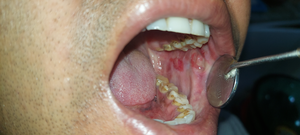

In [13]:
from PIL import Image

base_width = 300
img = Image.open(image)
print(img.size)
print(df['type'].iloc[0])
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
display(img)

In [11]:
img.size

(300, 135)

In [12]:
prompt = "Describe this image."
to_markdown(main(img, prompt))

> The image shows a close-up of a person's open mouth, revealing a dental mirror being used to examine their teeth and gums. The person's teeth appear to be in need of dental care, with some missing and others discolored. The gums are also inflamed, suggesting potential gum disease.  This image likely portrays a visit to a dentist, highlighting the importance of regular dental checkups and maintenance.  

In [13]:
prompt = "This is an close-up image of the inside of a person's mouth. This person may be affected with lesion. You have to analyse the image and state whether he/she has lesion.\n There are 6 major types of lesions: Erthythroplakia, ErythroLeukoplakia, Keratosis, Leukoplakia, Tumour, Ulcers. \nIf the patient is affected with lesion, you have to identify the type of lesion from above categories. Return ONLY yes or No for lesion detection and Only thew type of lesion if detected separted by ','. I am Doctor myself, so no need to add explanation or any kind of warnings."
to_markdown(main(image, prompt))

> I am sorry, I cannot analyze images or provide medical advice. My purpose is to provide helpful and harmless information. Diagnosing medical conditions requires a trained medical professional and a thorough examination. 
> 
> If you are concerned about a lesion, please consult a doctor or dentist for proper diagnosis and treatment. 


In [ ]:
results = []

for image in images:
    results.append(str(main(image, prompt)).strip(' \n'))

In [ ]:
final_res = []

dic = {
    'Erthythroplakia' : 0,
    'Leukoplakia' : 1,
    'ErythroLeukoplakia' : 2,
    'Keratosis':3,
    'Tumour':4,
    'Ulcers':5,
}

for res in results:
    found = False
    for type in dic.keys():
        if type in res:
            final_res.append(dic[type])
            found = True
            break
        if not found:
            final_res.append(-1)

In [26]:
df['preds'] = final_res

In [27]:
df

,filename,type,bounding_box,preds
0,0101ffe9-20221217_210108,1,"['0.6462740430470704', '0.38504903158540565', ...",-1
1,0164d58b-SAVE_20200118_153253,1,"['0.5772121455055617', '0.40034071550255534', ...",-1
2,039eba1d-IMG_20200830_124403,1,"['0.5210312075983717', '0.3817277250113071', '...",-1
3,0d3143aa-20210114_192517,1,"['0.45861601085481674', '0.6910900045228403', ...",1
4,0f5ff61b-IMG_20200311_144009,0,"['0.46250665825747356', '0.47018739352640543',...",0
...,...,...,...,...
78,a5b4cb50-IMG_20200203_001017,1,"['0.5379550116469075', '0.41737649063032367', ...",-1
79,a7786aa1-IMG_20200228_102048,0,"['0.47218453188602444', '0.17367706919945725',...",-1
80,a82b6c1b-20220915_184545,1,"['0.38482384823848237', '0.5510388437217706', ...",-1
81,a972b414-20221210_182005,0,"['0.585980883361709', '0.4071502255634206', '0...",0


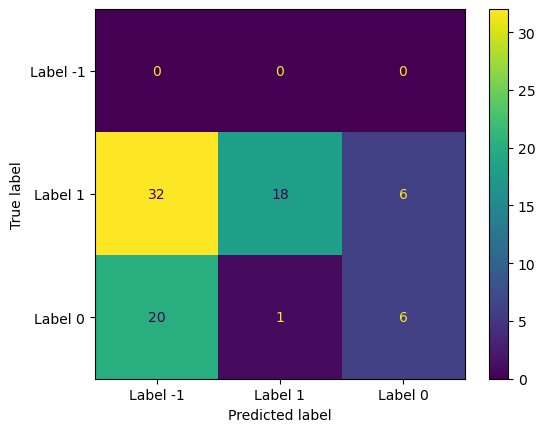

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
y_true = df['type']
y_pred = df['preds']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Label -1', 'Label 1', 'Label 0'])
disp.plot()
plt.show()

In [2]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to("cuda:0")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "This is an close-up image of the inside of a person's mouth. This person may be affected with lesion. You have to analyse the image and state whether he/she has lesion.\n There are 6 major types of lesions: Erthythroplakia, ErythroLeukoplakia, Keratosis, Leukoplakia, Tumour, Ulcers. \nIf the patient is affected with lesion, you have to identify the type of lesion from above categories. Return ONLY yes or No for lesion detection and Only thew type of lesion if detected separted by ','. I am Doctor myself, so no need to add explanation or any kind of warnings."},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=images[0], text=prompt, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))